<a href="https://colab.research.google.com/github/whuating0904/tool-practicum/blob/main/%E9%A1%A7%E5%AE%A2%E5%88%86%E6%9E%90_%E6%9C%9F%E4%B8%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import pandas as pd, numpy as np
customers =xl("tbl_customers[#ALL]", headers=True)
products =xl("tbl_products[#ALL]", headers=True)
tx = xl("tbl_tx[#ALL]", headers=True)
customers.shape, products.shape, tx.shape


NameError: name 'xl' is not defined

In [ ]:
import pandas as pd

# 檔案名稱
file_name = "商業顧客其中.xlsx"

# 讀取三個工作表
customers = pd.read_excel(file_name, sheet_name='tbl_customers', engine='openpyxl')
products = pd.read_excel(file_name, sheet_name='tbl_products', engine='openpyxl')
tx = pd.read_excel(file_name, sheet_name='tbl_tx', engine='openpyxl')

# 檢查每張表格的維度（列數, 欄數）
print("Customers:", customers.shape)
print("Products:", products.shape)
print("Transactions:", tx.shape)

# 預覽前五筆資料
print("\nCustomers preview:")
display(customers.head())

print("\nProducts preview:")
display(products.head())

print("\nTransactions preview:")
display(tx.head())


Customers: (500, 7)
Products: (50, 4)
Transactions: (3000, 17)

Customers preview:


,customer_id,age,gender,signup_date,country,loyalty_tier,email_optin
0,C0102,18,M,2024-07-11,SG,Bronze,True
1,C0145,18,F,2024-08-11,JP,Bronze,True
2,C0194,18,M,2023-11-05,UK,Silver,True
3,C0236,18,M,2024-06-03,SG,Bronze,True
4,C0279,18,M,2023-11-09,SG,Bronze,False



Products preview:


,product_id,product_name,category,base_price
0,P0001,Product_1,Home,7.68
1,P0002,Product_2,Beauty,53.43
2,P0003,Product_3,Apparel,46.81
3,P0004,Product_4,Electronics,57.81
4,P0005,Product_5,Grocery,53.27



Transactions preview:


,order_id,order_date,customer_id,product_id,product_name,category,unit_price,quantity,discount,channel,revenue,年,月,季度,loyalty_tier,country,age
0,O01915,2024-06-13,C0320,P0025,Product_25,Apparel,184.55,10,0.0,Online,1845.50,2024-06-13,6,Q2,Bronze,US,44
1,O00913,2024-05-31,C0227,P0025,Product_25,Apparel,184.55,9,0.0,Store,1660.95,2024-05-31,5,Q2,Bronze,US,34
2,O01511,2024-07-21,C0043,P0040,Product_40,Electronics,187.57,8,0.0,Store,1500.56,2024-07-21,7,Q3,Platinum,US,68
3,O01960,2024-04-21,C0270,P0013,Product_13,Beauty,168.51,8,0.0,Store,1348.08,2024-04-21,4,Q2,Gold,SG,49
4,O00914,2024-08-02,C0423,P0021,Product_21,Electronics,148.89,9,0.0,Online,1340.01,2024-08-02,8,Q3,Bronze,UK,44


In [ ]:
#基本資料清理:日期 折扣 安全欄位
tx = tx.copy()
tx["order_date"] = pd.to_datetime(tx["order_date"])
tx["discount"] = tx["discount"].fillna(0.0)
clean_info = {
    "nulls": tx.isna().sum().to_dict(),
    "date_range": (str(tx["order_date"].min().date()), str(tx["order_date"].max().date()))
}
clean_info

{'nulls': {'order_id': 0,
  'order_date': 0,
  'customer_id': 0,
  'product_id': 0,
  'product_name': 0,
  'category': 0,
  'unit_price': 0,
  'quantity': 0,
  'discount': 0,
  'channel': 0,
  'revenue': 0,
  '年': 0,
  '月': 0,
  '季度': 0,
  'loyalty_tier': 0,
  'country': 0,
  'age': 0,
  'month': 0},
 'date_range': ('2024-01-01', '2024-09-30')}

In [ ]:
#設定觀測日
SNAPSHOT_DATE = tx["order_date"].max() + pd.Timedelta(days=1)
SNAPSHOT_DATE

Timestamp('2024-10-01 00:00:00')

In [ ]:
#產品月營收與佔比
tx["month"] = tx["order_date"].values.astype("datetime64[M]")
prod_month = (tx.groupby(["product_id","product_name","month"])["revenue"].sum()
                .rename("rev").reset_index())
total_month = prod_month.groupby("month")["rev"].sum().rename("total_rev")
prod_month = prod_month.merge(total_month, on="month")
prod_month["share"] = prod_month["rev"] / prod_month["total_rev"]
prod_month.head(6)

,product_id,product_name,month,rev,total_rev,share
0,P0001,Product_1,2024-01-01,105.22,99433.03,0.001058
1,P0001,Product_1,2024-02-01,110.59,91642.12,0.001207
2,P0001,Product_1,2024-03-01,193.15,111805.69,0.001728
3,P0001,Product_1,2024-04-01,46.08,98741.10,0.000467
4,P0001,Product_1,2024-05-01,220.42,93242.82,0.002364
5,P0001,Product_1,2024-06-01,221.57,97297.11,0.002277


In [ ]:
#動能分析：近三月 VS 前三月成長率
last_month = tx["month"].max()
months = pd.period_range(last_month - pd.DateOffset(months=5), last_month, freq="M").to_timestamp()
recent3, prior3 = months[-3:], months[:3]
pm = prod_month.pivot_table(index=["product_id","product_name"], columns="month", values="rev", fill_value=0)
grow = pd.DataFrame(index=pm.index)
grow["rev_recent3"] = pm.reindex(columns=recent3).sum(axis=1)
grow["rev_prior3"]  = pm.reindex(columns=prior3).sum(axis=1)
grow["growth_rate"] = np.where(grow["rev_prior3"]>0, (grow["rev_recent3"]-grow["rev_prior3"])/grow["rev_prior3"], np.nan)
grow.reset_index().head(10)

,product_id,product_name,rev_recent3,rev_prior3,growth_rate
0,P0001,Product_1,418.17,488.07,-0.143217
1,P0002,Product_2,2834.45,3184.42,-0.109901
2,P0003,Product_3,2752.43,1451.11,0.896776
3,P0004,Product_4,2754.65,3338.54,-0.174894
4,P0005,Product_5,1427.63,3039.06,-0.530240
5,P0006,Product_6,946.30,767.52,0.232932
6,P0007,Product_7,5093.00,4559.14,0.117097
7,P0008,Product_8,6321.88,7260.90,-0.129326
8,P0009,Product_9,5659.93,5055.71,0.119512
9,P0010,Product_10,7859.33,7205.52,0.090737


In [ ]:
#顧客購物籃分析
from itertools import combinations
baskets = (tx.groupby("order_id")["product_id"].apply(lambda s: sorted(set(s))).reset_index())
baskets.head()

,order_id,product_id
0,O00001,[P0015]
1,O00002,[P0001]
2,O00003,[P0003]
3,O00004,[P0014]
4,O00005,[P0038]


In [ ]:
# 計算每筆訂單商品數量
baskets["num_products"] = baskets["product_id"].apply(len)

# 查看前 10 筆
baskets.head(10)

# 有多商品的訂單數量
multi_product_count = (baskets["num_products"] > 1).sum()
print("Number of orders with >1 product:", multi_product_count)

In [ ]:
#目前資料中根本沒有訂單同時買多個商品，因此共構計算無法產生資料。
#明星商品綜合評分 = 營收占比60% + 成長動能40% + 共構帶動0%

In [ ]:
# 計算近3月占比
share3 = (prod_month[prod_month["month"].isin(recent3)]
          .groupby(["product_id","product_name"])["share"]
          .mean()
          .rename("share3"))

# 建立明星商品表
star = share3.to_frame().join(
    grow[["rev_recent3","rev_prior3","growth_rate"]], how="left")


# Z-score 標準化函數
def z(s):
    return (s - s.mean()) / s.std(ddof=0) if s.std(ddof=0) > 0 else s*0

# 計算 Z-score
star["z_share"]  = z(star["share3"])
star["z_growth"] = z(star["growth_rate"])


# 計算明星商品綜合評分（權重 60% 營收占比、40% 成長、0% 共構）
star["star_score"] = 0.6*star["z_share"] + 0.4*star["z_growth"]

# 排序並重置索引
star = star.sort_values("star_score", ascending=False).reset_index()

# 顯示 Top 15
print(star.head(15))

   product_id product_name    share3  rev_recent3  rev_prior3  growth_rate  \
0       P0039   Product_39  0.037235     11701.02     3770.91     2.102970   
1       P0030   Product_30  0.045299     13163.94     8530.51     0.543160   
2       P0013   Product_13  0.044270     13784.13    12318.09     0.119015   
3       P0036   Product_36  0.027485      8589.25     4355.21     0.972178   
4       P0016   Product_16  0.044167     13455.37    12894.73     0.043478   
5       P0015   Product_15  0.037480     11343.65     8331.92     0.361469   
6       P0032   Product_32  0.041311     12968.59    11946.01     0.085600   
7       P0040   Product_40  0.039972     12192.06    10578.93     0.152485   
8       P0012   Product_12  0.033677     10413.02     8955.38     0.162767   
9       P0025   Product_25  0.037962     11442.10    13315.28    -0.140679   
10      P0014   Product_14  0.031965      9654.59     8455.88     0.141761   
11      P0017   Product_17  0.031111      9390.47     8079.15   

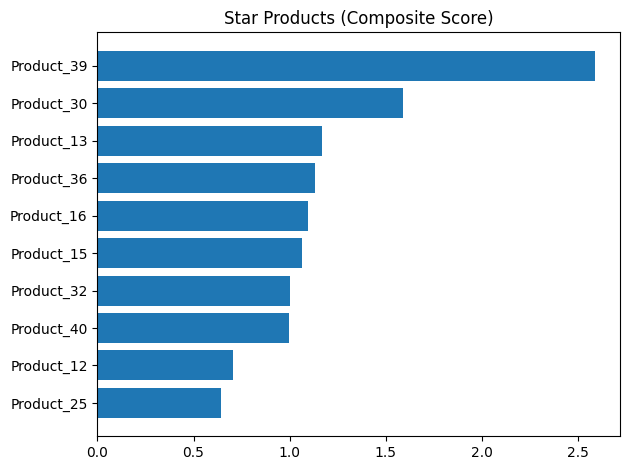

In [ ]:
import matplotlib.pyplot as plt
top10 = star.head(10).sort_values("star_score")
plt.figure()
plt.barh(top10["product_name"], top10["star_score"])
plt.title("Star Products (Composite Score)")
plt.tight_layout()

In [ ]:
pm_ch = (tx.groupby(["channel","product_id","product_name","month"])["revenue"]
            .sum().rename("rev").reset_index())
last3 = pm_ch["month"].max() - pd.offsets.MonthBegin(2)
pm_ch3 = pm_ch[pm_ch["month"]>=last3]
top_online = (pm_ch3[pm_ch3["channel"]=="Online"].groupby(["product_id","product_name"])["rev"].sum()
               .sort_values(ascending=False).head(10).rename("rev_online"))
top_store  = (pm_ch3[pm_ch3["channel"]=="Store"].groupby(["product_id","product_name"])["rev"].sum()
               .sort_values(ascending=False).head(10).rename("rev_store"))
pd.concat([top_online, top_store], axis=1).fillna("")

,,rev_online,rev_store
product_id,product_name,,
P0030,Product_30,10739.48,
P0013,Product_13,10312.81,3471.32
P0015,Product_15,10077.73,
P0039,Product_39,9871.5,
P0014,Product_14,8731.25,
P0032,Product_32,8624.59,4344.0
P0050,Product_50,7004.28,2926.19
P0016,Product_16,6596.87,6858.5
P0010,Product_10,6517.66,


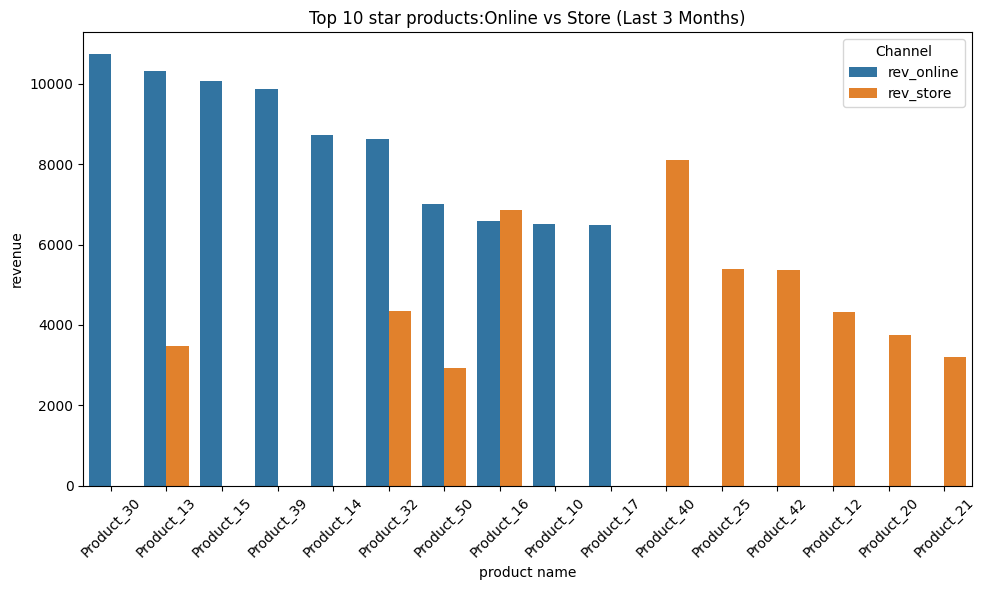

In [ ]:
import matplotlib.pyplot as plt

top = pd.concat([top_online, top_store], axis=1).fillna(0)

# 轉換成長格式方便畫圖
top_plot = top.reset_index().melt(id_vars=["product_name"],
                                  value_vars=["rev_online","rev_store"],
                                  var_name="channel",
                                  value_name="revenue")

plt.figure(figsize=(10,6))
import seaborn as sns
sns.barplot(data=top_plot, x="product_name", y="revenue", hue="channel")
plt.xticks(rotation=45)
plt.title("Top 10 star products:Online vs Store (Last 3 Months)")
plt.ylabel("revenue")
plt.xlabel("product name")
plt.legend(title="Channel")
plt.tight_layout()
plt.show()

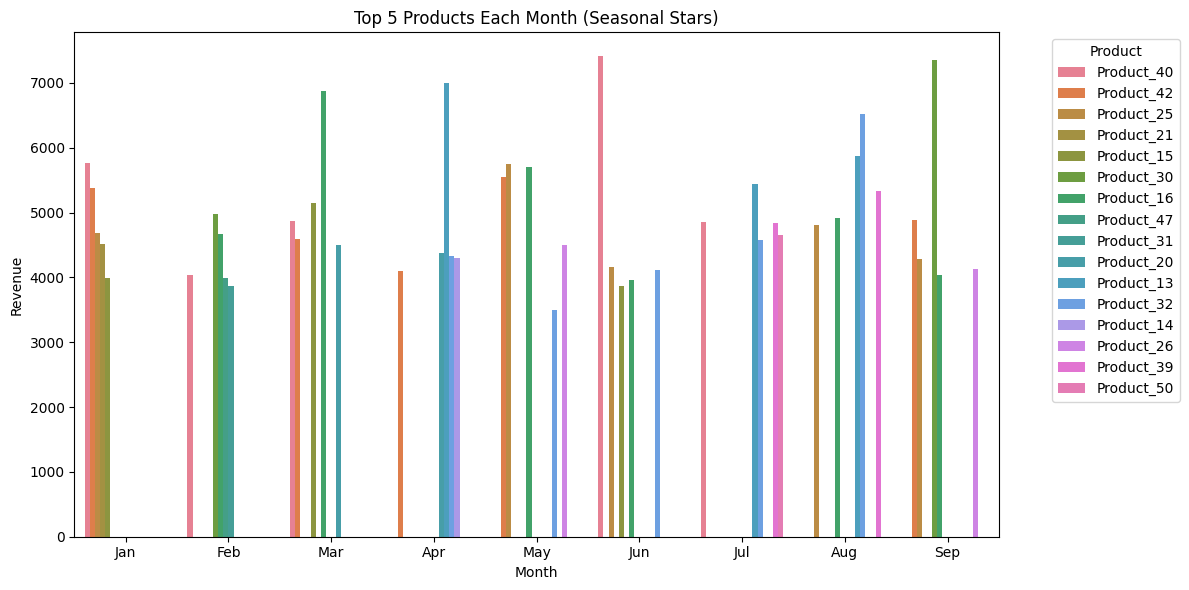

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

N = 5

# 先準備資料
m_top = (prod_month.assign(month_num=prod_month["month"].dt.month)
         .sort_values(["month","rev"], ascending=[True,False])
         .groupby("month").head(N)[["month","product_name","rev"]])

# 將 month 轉成字串方便圖表顯示
m_top["month_str"] = m_top["month"].dt.strftime("%b")  # Jan, Feb...

plt.figure(figsize=(12,6))
sns.barplot(data=m_top, x="month_str", y="rev", hue="product_name")
plt.title(f"Top {N} Products Each Month (Seasonal Stars)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
pq = tx.groupby(["product_id","product_name","month"]).agg(
    qty=("quantity","sum"),
    price=("unit_price","mean")
).reset_index()

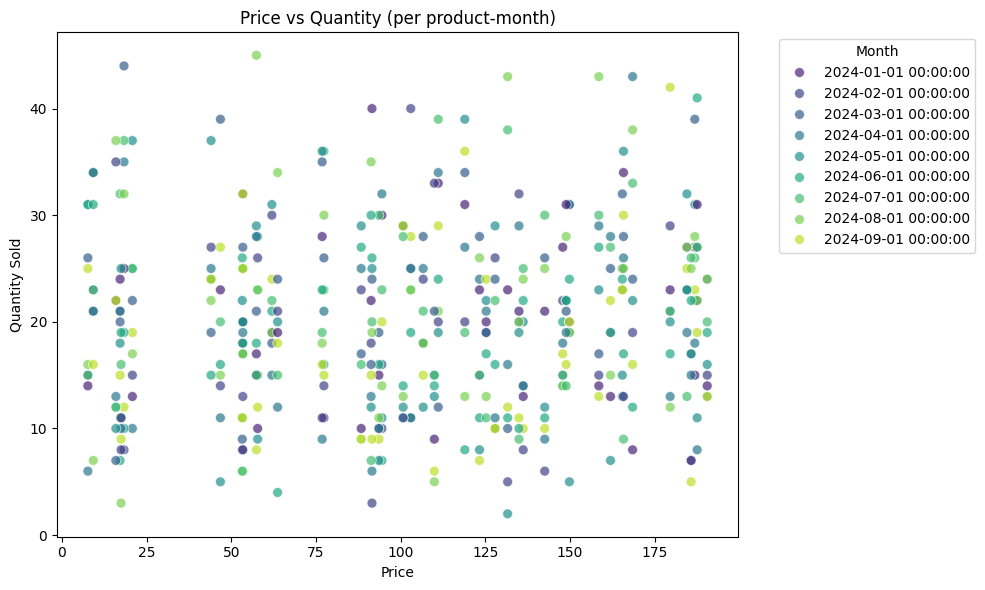

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=pq, x="price", y="qty", hue="month", palette="viridis", s=50, alpha=0.7)
plt.title("Price vs Quantity (per product-month)")
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


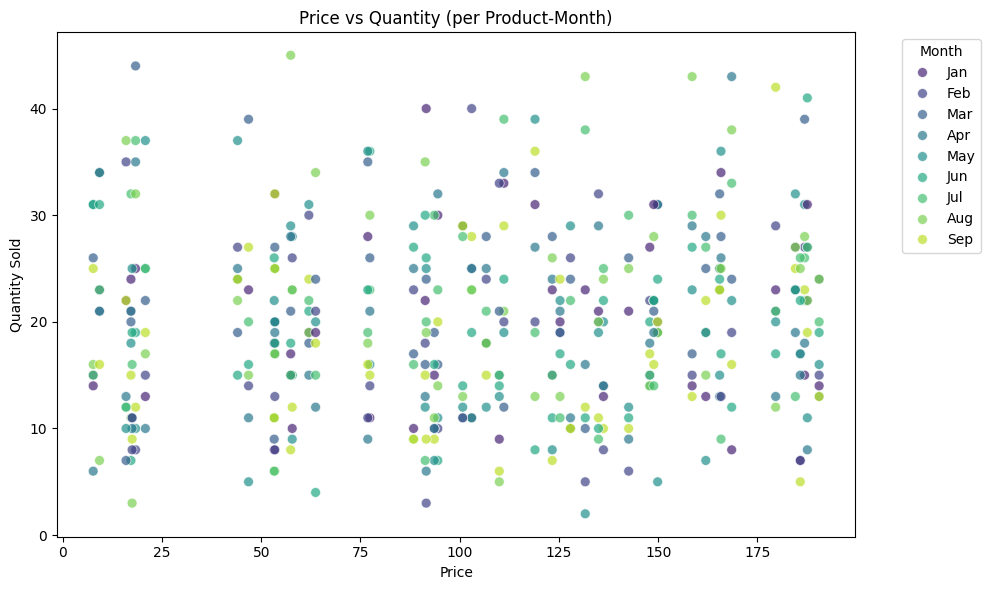

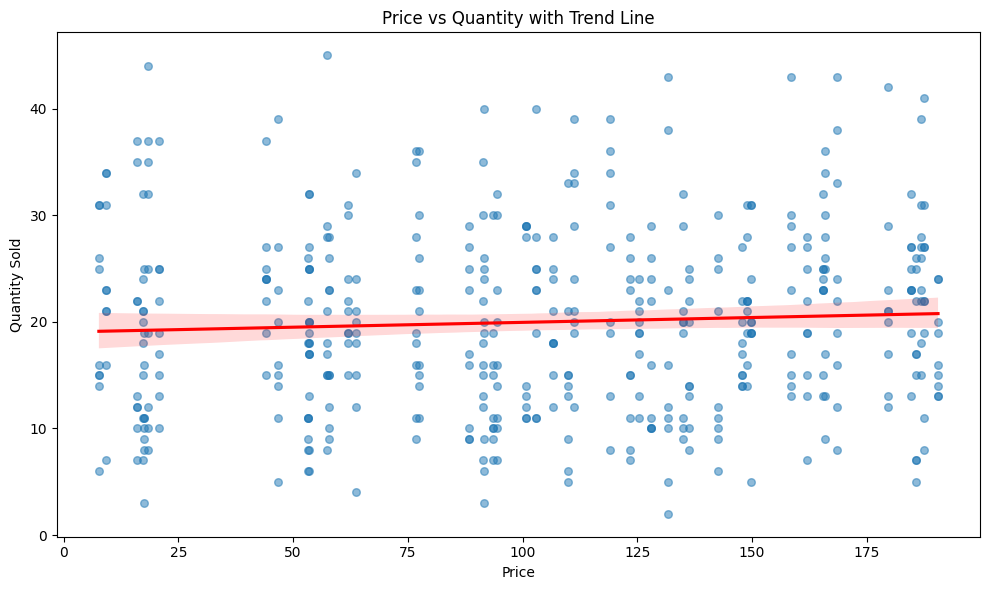

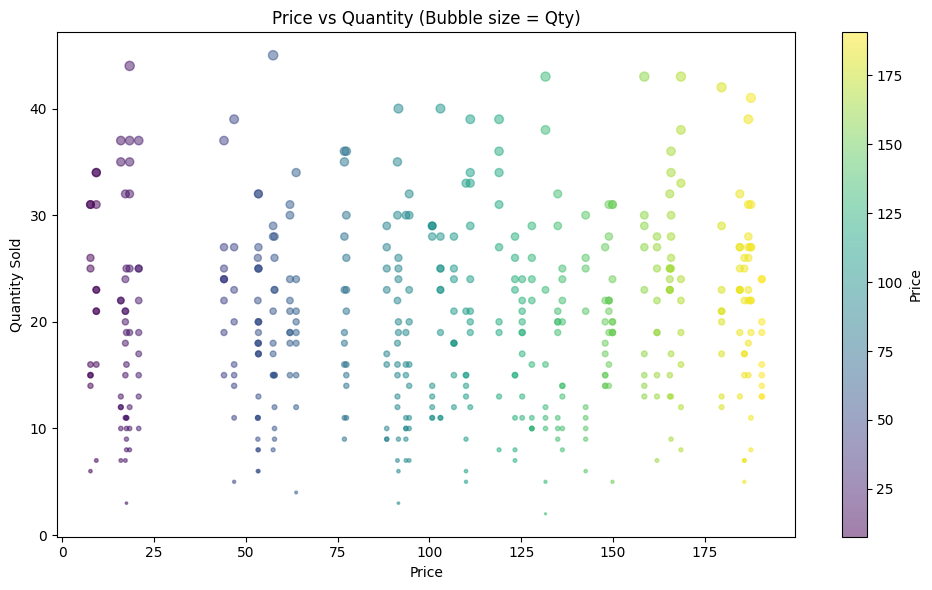

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2️⃣ 假設 tx 已經匯入，確認必要欄位
# tx columns: ['product_id','product_name','month','quantity','unit_price']
# 如果 month 不是 datetime，先轉換
tx["month"] = pd.to_datetime(tx["month"])

# 3️⃣ 建立 product-month 的價格與數量資料
pq = tx.groupby(["product_id","product_name","month"]).agg(
    qty=("quantity","sum"),
    price=("unit_price","mean")
).reset_index()

# 4️⃣ 散點圖：每月產品價格 vs 銷量
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=pq,
    x="price",
    y="qty",
    hue=pq["month"].dt.strftime("%b"),  # 顏色區分月份
    palette="viridis",
    s=50, alpha=0.7
)
plt.title("Price vs Quantity (per Product-Month)")
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5️⃣ 散點圖 + 趨勢線（整體價格彈性）
plt.figure(figsize=(10,6))
sns.regplot(
    data=pq,
    x="price",
    y="qty",
    scatter_kws={"s":30, "alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Price vs Quantity with Trend Line")
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

# 6️⃣ 氣泡圖：點大小代表銷量
plt.figure(figsize=(10,6))
plt.scatter(
    pq["price"],
    pq["qty"],
    s=pq["qty"],  # 氣泡大小 = 銷量
    alpha=0.5,
    c=pq["price"], cmap="viridis"
)
plt.colorbar(label="Price")
plt.title("Price vs Quantity (Bubble size = Qty)")
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()